## Preparing Image Data

In [50]:
# pixel normalization
from numpy import asarray
from PIL import Image
# load image
image = Image.open('bondi_beach.jpg')
pixels = asarray(image)
# confirm range 0-255
print("=== Confirming Range ===")
print('Data Type: %s' % pixels.dtype)
print('Min: %.3f, Max: %.3f' % (pixels.min(), pixels.max()))
# convert from int to float
pixels = pixels.astype('float32')
# normalize 0-1
pixels /= 255.0
print("=== Normalizing ===")
print('Min: %.3f, Max: %.3f' % (pixels.min(), pixels.max()))

# We have normalized the values, but we can also standardize them,
# transforming the distribution to a standard Gaussian (centering
# the pixel values on zero and normalizing w/ standard deviation)

# get mean and standard deviation
mean, std = pixels.mean(), pixels.std()
print("=== Standardizing ===")
print('Mean: %.3f, Std Dev: %.3f' % (mean, std))
# standardize
pixels = (pixels - mean) / std
mean, std = pixels.mean(), pixels.std()
print('Mean: %.3f, Std Dev: %.3f' % (mean, std))
print('Min: %.3f, Max: %.3f' % (pixels.min(), pixels.max()))
# this introduces a potential issue where our min is negative and our max is over 1
# we can clip to -1 and 1 and rescale to 0 and 1
# from numpy import clip
pixels = clip(pixels, -1.0, 1.0)
pixels = (pixels + 1.0) / 2.0
mean, std = pixels.mean(), pixels.std()
print("=== Clipping ===")
print('Mean: %.3f, Std Dev: %.3f' % (mean, std))
print('Min: %.3f, Max: %.3f' % (pixels.min(), pixels.max()))

=== Confirming Range ===
Data Type: uint8
Min: 0.000, Max: 255.000
=== Normalizing ===
Min: 0.000, Max: 1.000
=== Standardizing ===
Mean: 0.610, Std Dev: 0.202
Mean: 0.000, Std Dev: 1.000
Min: -3.019, Max: 1.930
=== Clipping ===
Mean: 0.539, Std Dev: 0.377
Min: 0.000, Max: 1.000


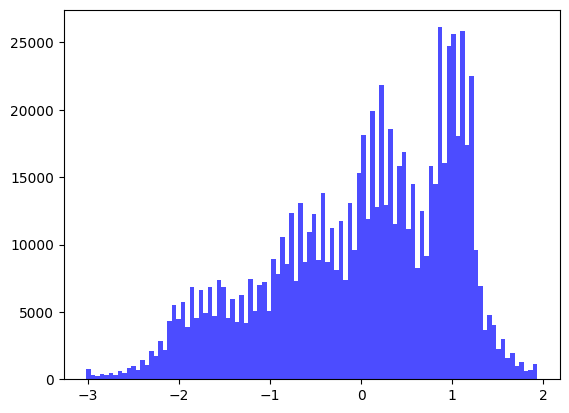

In [48]:
# Now let's look at our distribution

pixels = pixels.flatten()
plt.hist(pixels,bins=100,color='blue',alpha=0.7)
plt.show()

Means: [131.41411007 153.1192257  182.1233387 ], Stds: [58.18740883 40.11213778 40.92859711]
Means: [ 6.47491987e-16  1.21311307e-12 -1.03400083e-13], Stds: [1. 1. 1.]


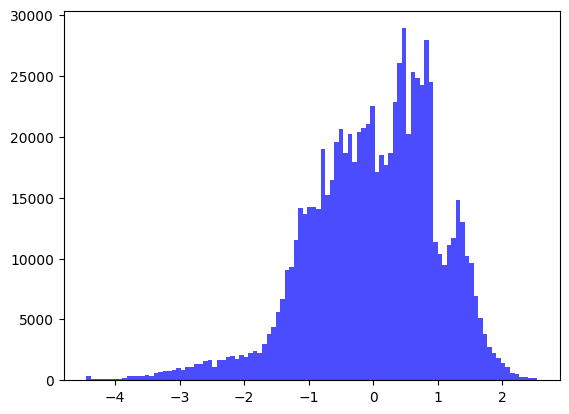

In [54]:
# We can also look at local standardization and calculate the mean and std dev per channel

# load image
image = Image.open('bondi_beach.jpg')
pixels = asarray(image)
# convert from integers to floats
pixels = pixels.astype('float32')
# calculate per-channel means and standard deviations
means = pixels.mean(axis=(0,1), dtype='float64')
stds = pixels.std(axis=(0,1), dtype='float64')
print('Means: %s, Stds: %s' % (means, stds))
# per-channel standardization of pixels
pixels = (pixels - means) / stds
# confirm it had the desired effect
means = pixels.mean(axis=(0,1), dtype='float64')
stds = pixels.std(axis=(0,1), dtype='float64')
print('Means: %s, Stds: %s' % (means, stds))
pixels = pixels.flatten()
plt.hist(pixels,bins=100,color='blue',alpha=0.7)
plt.show()


## CNN

Convolution: Application of a filter to an input that results in an activation. Repeated applications of the same filter to an input results in a map of activations called a feature map. A convolutional layer can be created by specifying the number of filters to learn and the fixed size of each filter (kernel shape)

Pooling: Downsampling feature maps by summarizing the presence of features in patches of the feature map. Max pooling calculate the maximum value in each patch of each feature map

Classifier Layer: Flatten the 2-dim feature maps and add a fully connected output layer. For binary classification the output layer would have one node that would predict a value between 0 and 1 for the two classes. For multi-class classification the output layer would have a node for each class with a value between 0 and 1 for the probability that class is correct.

In [72]:
# Using Keras
# CNN with single convolutional, pooling, and output layer
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

# create model
model = Sequential()
# add convolutional layer
model.add(Conv2D(32, (3,3), input_shape=(256,256,1)))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_24 (Conv2D)              │ (None, 254, 254, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_15 (Flatten)            │ (None, 516128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 1)              │       516,129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 516,449 (1.97 MB)

 Trainable params: 516,449 (1.97 MB)

 Non-trainable params: 0 (0.00 B)

## Image Classification

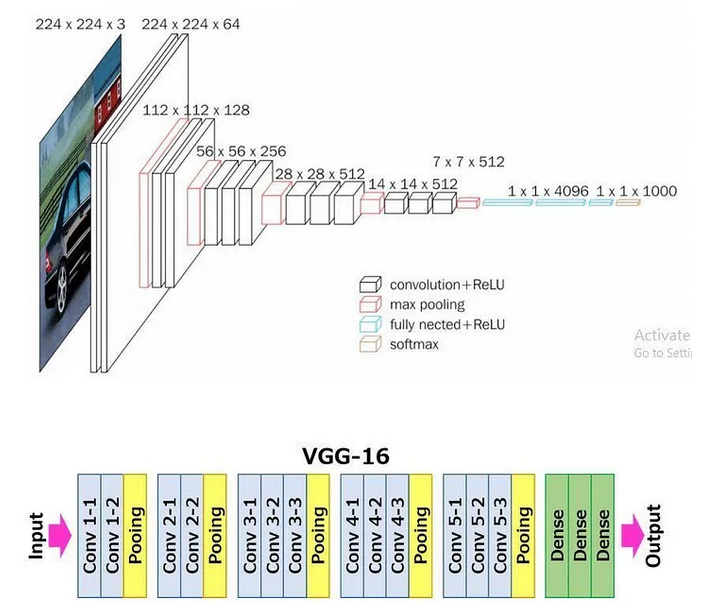

In [84]:
# using pre-trained model
from keras.preprocessing.image import load_img
from keras.applications.vgg16 import preprocess_input, decode_predictions, VGG16
# VGG-16 is a 16 layer CNN used for object detection and classification
# able to classify 1000 images of 1000 different categories with 92.7% accuracy
# 13 convolution layers, 5 max-pooling layers, and 3 dense layers (21 layers) but only 16 have learnable weights

def predict(image_path):
    image = load_img(image_path, target_size=(224, 224)) # input size for VGG-16 architecture
    image = asarray(image) # convert to np array
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    image = preprocess_input(image) # preprocess
    model = VGG16() # load model
    yhat = model.predict(image) # predict probabilities on output classes
    label = decode_predictions(yhat) # convert to label
    label = label[0][0]
    print('%s (%.2f%%)' % (label[1], label[2]*100))

In [89]:
predict('dog.jpg')
predict('cat.jpg')
predict('bondi_beach.jpg')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
Doberman (36.90%)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
Siamese_cat (94.47%)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
seashore (74.18%)
